In [1]:
%matplotlib inline

import cv2
import scipy.interpolate
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def createCurve(points):
    if points is None:
        return None
    nPoints = len(points)
    if nPoints < 2:
        return None
    x, y = zip(*points)
    if nPoints < 4:
        kind = 'linear'
    else:
        kind = 'cubic'
    
    return scipy.interpolate.interp1d(x, y, kind, bounds_error=False)

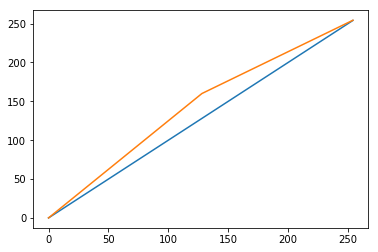

In [3]:
curve = createCurve([(0,0),(128,160),(255,255)])

x = np.arange(0,255,1)
y = curve(x)

plt.plot(x,x,'-',x,y,'-')
plt.show()

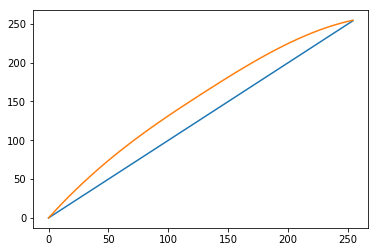

In [4]:
curve = createCurve([(0,0),(80,110),(128,160),(170,200),(255,255)])

x = np.arange(0,255,1)
y = curve(x)

plt.plot(x,x,'-',x,y,'-')
plt.show()

In [5]:
def createCache(f,l=256):
    if f is None:
        return None
    cache = np.empty(l)
    for i in range(l):
        f_i = f(i)
        cache[i] = min(max(0,f_i),l-1)
    return cache

In [6]:
def applyCache(cache,src,dst):
    if cache is None:
        return
    dst[:] = cache[src]

In [7]:
def createComposite(f0,f1):
    if f0 is None:
        return f1
    if f1 is None:
        return f0
    return lambda x: f0(f1(x))

In [8]:
def flatView(array):
    view = array.view()
    view.shape = array.size
    return view

In [9]:
class VFuncFilter(object):
    def __init__(self, f = None, dtype = np.uint8):
        l = np.iinfo(dtype).max + 1
        self._cache = createCache(f,l)
        
    def apply(self, src, dst):
        flatSrc = flatView(src)
        flatDst = flatView(dst)
        applyCache(self._cache,flatSrc,flatDst)

In [10]:
class VCurveFilter(VFuncFilter):
    def __init__(self,points,dtype = np.uint8):
        VFuncFilter.__init__(self, createCurve(points),dtype)

In [11]:
class BGRFuncFilter(object):
    def __init__(self, f_v = None, f_b = None, f_g = None, f_r = None, dtype = np.uint8):
        l = np.iinfo(dtype).max + 1
        self._blueCache  = createCache(createComposite(f_b,f_v), l)
        self._greenCache = createCache(createComposite(f_g,f_v), l)
        self._redCache   = createCache(createComposite(f_r,f_v), l)
        
    def apply(self, src, dst):
        b, g, r = cv2.split(src)
        applyCache(self._blueCache, b,b)
        applyCache(self._greenCache,g,g)
        applyCache(self._redCache,  r,r)
        cv2.merge([b,g,r], dst)

In [12]:
class BGRCurveFilter(BGRFuncFilter):
    def __init__(self,vPoints = None, bPoints = None, gPoints = None, rPoints = None, dtype = np.uint8):
        BGRFuncFilter.__init__(self,
                              createCurve(vPoints),
                              createCurve(bPoints),
                              createCurve(gPoints),
                              createCurve(rPoints), dtype)

http://www.prime-junta.net/pont/How_to/100_Curves_and_Films/_Curves_and_films.html

In [13]:
class KodakPortraFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               vPoints = [(0,0),(23,20),(205,227),(255,255)],
                               bPoints = [(0,0),(41,46),(231,228),(255,255)],
                               gPoints = [(0,0),(52,47),(189,196),(255,255)],
                               rPoints = [(0,0),(69,69),(213,218),(255,255)],
                               dtype = dtype)

In [14]:
class FujiProviaFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               bPoints = [(0,0),(35,25),(205,227),(255,255)],
                               gPoints = [(0,0),(27,21),(196,207),(255,255)],
                               rPoints = [(0,0),(59,54),(202,210),(255,255)],
                               dtype = dtype)

In [15]:
class FujiVelviaFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               vPoints = [(0,0),(128,118),(221,215),(255,255)],
                               bPoints = [(0,0),(25,21),(122,153),(165,206),(255,255)],
                               gPoints = [(0,0),(25,21),(95,102),(181,208),(255,255)],
                               rPoints = [(0,0),(41,28),(183,209),(255,255)],
                               dtype = dtype)

In [16]:
class CrossProcessingFilter(BGRCurveFilter):
    def __init__(self,dtype = np.uint8):
        BGRCurveFilter.__init__(self,
                               bPoints = [(0,20),(255,235)],
                               gPoints = [(0,0),(56,39),(208,226),(255,255)],
                               rPoints = [(0,0),(56,22),(211,255),(255,255)],
                               dtype = dtype)

In [17]:
kodakFilter  = KodakPortraFilter()
proviaFilter = FujiProviaFilter()
velviaFilter = FujiVelviaFilter()
crossFilter  = CrossProcessingFilter()

In [18]:
bgr_image = cv2.imread('portrait.jpg')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

In [19]:
kodak  = bgr_image.copy()
provia = bgr_image.copy()
velvia = bgr_image.copy()
cross  = bgr_image.copy()

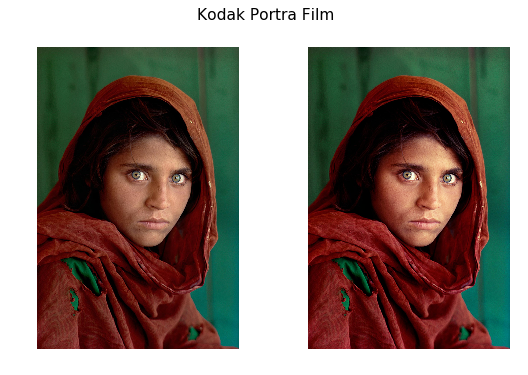

In [20]:
kodakFilter.apply(kodak,kodak); kodak = cv2.cvtColor(kodak, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Kodak Portra Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(kodak)

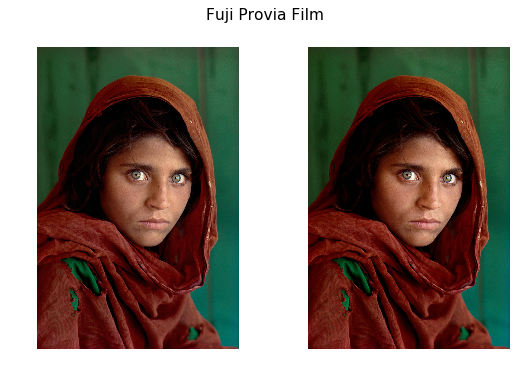

In [21]:
proviaFilter.apply(provia,provia); provia = cv2.cvtColor(provia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Fuji Provia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(provia)

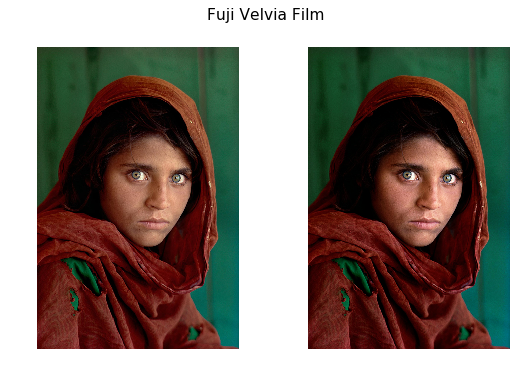

In [22]:
velviaFilter.apply(velvia,velvia); velvia = cv2.cvtColor(velvia, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Fuji Velvia Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(velvia)

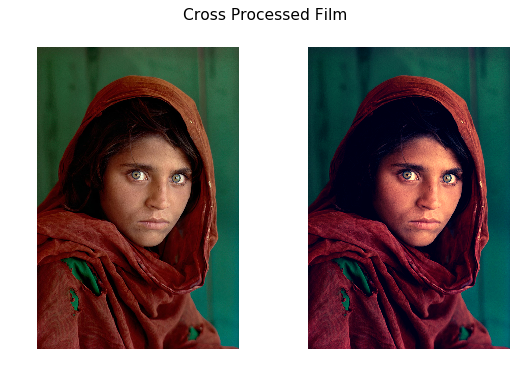

In [23]:
crossFilter.apply(cross,cross); cross = cv2.cvtColor(cross, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8.0,5.0); fig.set_dpi(80)
fig.suptitle('Cross Processed Film',fontsize=14)

ax[0].set_axis_off();ax[1].set_axis_off()
ax[0].imshow(rgb_image); ax[1].imshow(cross)